In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [26]:
data = pd.read_excel('Final Dataset.xlsx', index_col=0)

In [27]:
data = data.iloc[1:,:]

In [28]:
# separate exogenous variables for all companies from the prices volumes and tradig ranges

exogenous = data[['Close_10YBond',
    'Reference rate',
    'Close_EUR/PLN', 'Close_Oil',
    'Close_VIX']]

stocks = data.loc[:, :'Trading range_sWIG80']

pko = pd.DataFrame(stocks['Close_PKO'])
pko_exo = pd.concat((stocks[['Trading range_PKO']],exogenous), axis=1)

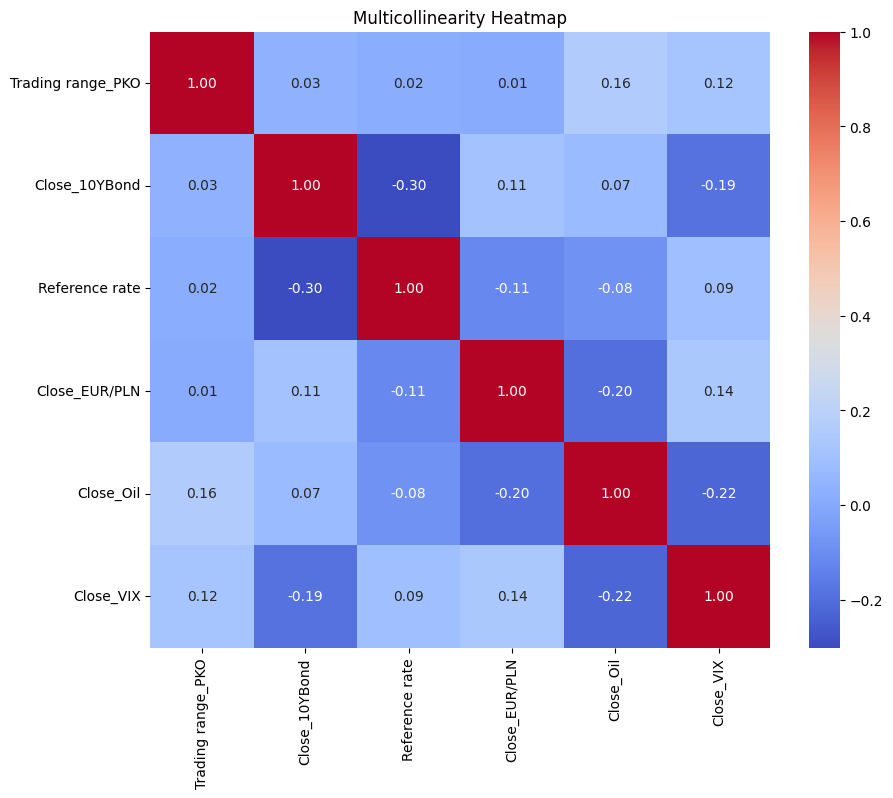

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Load your dataframe
# df = pd.read_csv('your_data.csv')

# Compute the correlation matrix
correlation_matrix = pko_exo.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

# Set the title
plt.title('Multicollinearity Heatmap')
plt.show()

In [30]:
# Check stationarity of the data

for i in pko_exo.columns:
    result = adfuller(pko_exo[i])

    # If p-value > 0.05, data is non-stationary and needs differencing
    if result[1] > 0.05:
        print("Data is non-stationary. Differencing is required.")
    else:
        print("Data is stationary.")

Data is stationary.
Data is non-stationary. Differencing is required.
Data is stationary.
Data is stationary.
Data is non-stationary. Differencing is required.
Data is stationary.


In [31]:
# if data non stationary apply differencing

for i in pko_exo.columns:
    if adfuller(pko_exo[i].dropna())[1] > 0.05:
        pko_exo[i] = pko_exo[i].diff().dropna()

In [32]:
# Get rid of first row bcs it has nan values after the differencing

pko_exo = pko_exo.iloc[1:,:]


In [33]:
# Check stationarity of the data after differencing

for i in pko_exo.columns:
    result = adfuller(pko_exo[i])

    # If p-value > 0.05, data is non-stationary and needs differencing
    if result[1] > 0.05:
        print("Data is non-stationary. Differencing is required.")
    else:
        print("Data is stationary.")

Data is stationary.
Data is stationary.
Data is stationary.
Data is stationary.
Data is stationary.
Data is stationary.


In [34]:
result = adfuller(pko['Close_PKO'])

# If p-value > 0.05, data is non-stationary and needs differencing
if result[1] > 0.05:
    print("Data is non-stationary. Differencing is required.")
else:
    print("Data is stationary.")

Data is non-stationary. Differencing is required.


In [35]:
pko['Close_PKO'] = pko['Close_PKO'].diff().dropna()

In [36]:
pko = pko.iloc[1:]

In [37]:
pko_exo_shifted = pko_exo.shift(1).dropna()
pko = pko.iloc[1:]

In [38]:
X_train = pko_exo_shifted[pko_exo_shifted.index < "2019-01-01"]
X_test = pko_exo_shifted[pko_exo_shifted.index >= "2019-01-01"]
y_train =  pko[pko.index < "2019-01-01"]
y_test = pko[pko.index >= "2019-01-01"]


In [43]:
# Convert training and testing data to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [74]:
params = {
    'objective': 'reg:squarederror',  # Regression task
    'max_depth': 100,                  # Maximum depth of the trees
    'eta': 0.1,                      # Learning rate
    'subsample': 0.8,                # Fraction of samples to use for each tree
    'colsample_bytree': 0.8,         # Fraction of features to use for each tree
    'lambda': 1,                     # L2 regularization
    'alpha': 0,                      # L1 regularization
    'eval_metric': 'rmse'            # Evaluation metric: root mean square error
}


# Define evaluation sets
evals = [(dtrain, 'train'), (dtest, 'test')]

# Train the model
model = xgb.train(params, dtrain, num_boost_round=100, evals=evals, early_stopping_rounds=10, verbose_eval=True)


# Initialize predictions array
rolling_predictions = []

# Start with the initial training set
X_train_rolling = X_train.copy()
y_train_rolling = y_train.copy()

# Loop through the test data for rolling predictions
for i in range(len(X_test)):
    # Train the model on the rolling training data
    dtrain_rolling = xgb.DMatrix(X_train_rolling, label=y_train_rolling)
    model_rolling = xgb.train(params, dtrain_rolling, num_boost_round=100, verbose_eval=False)
    
    # Make a prediction for the current test point
    dtest_current = xgb.DMatrix(X_test.iloc[i:i+1])  # Use the current test point
    pred = model_rolling.predict(dtest_current)
    rolling_predictions.append(pred[0])
    
    # Add the current test point to the rolling training set using pd.concat
    X_train_rolling = pd.concat([X_train_rolling, X_test.iloc[i:i+1]])
    y_train_rolling = pd.concat([y_train_rolling, y_test.iloc[i:i+1]])

# Convert predictions to a NumPy array
rolling_predictions = pd.DataFrame(index=y_test.index, data=rolling_predictions, columns=['Predicted diff'])


In [77]:
rolling_predictions['Actual diff'] = y_test['Close_PKO']
rolling_predictions = pd.merge(rolling_predictions, stocks['Close_PKO'], left_index=True, right_index=True)

In [78]:
rolling_predictions['Actual reversed'] = rolling_predictions['Actual diff'] + rolling_predictions['Close_PKO'].shift(1)
rolling_predictions['Reversed values'] = rolling_predictions['Predicted diff'] + rolling_predictions['Close_PKO'].shift(1)

In [79]:
rolling_predictions

,Predicted diff,Actual diff,Close_PKO,Actual reversed,Reversed values
2019-01-01,-0.100606,0.000000,39.470001,NaN,NaN
2019-01-02,0.139251,1.029999,40.500000,40.500000,39.609252
2019-01-03,0.022354,-0.930000,39.570000,39.570000,40.522354
2019-01-04,-0.004049,0.880001,40.450001,40.450001,39.565950
2019-01-07,-0.087789,0.450001,40.900002,40.900002,40.362212
...,...,...,...,...,...
2019-12-24,-0.074184,0.000000,34.669998,34.669998,34.595814
2019-12-25,-0.134913,0.000000,34.669998,34.669998,34.535085
2019-12-26,0.123993,0.000000,34.669998,34.669998,34.793991
2019-12-27,-0.082215,-0.129997,34.540001,34.540001,34.587783


In [81]:
import xgboost as xgb
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 6, 10],         # Test different tree depths
    'eta': [0.01, 0.1, 0.2],        # Learning rates
    'subsample': [0.8, 1.0],        # Subsampling rates
    'colsample_bytree': [0.8, 1.0], # Column sampling
    'lambda': [1, 2],               # L2 regularization
    'alpha': [0, 1],                # L1 regularization
}

# Generate all combinations of the hyperparameters
grid = ParameterGrid(param_grid)

# Initialize a list to store results
results_list = []

# Loop through each combination of hyperparameters
for params in grid:
    # Initialize predictions array
    rolling_predictions = []

    # Start with the initial training set
    X_train_rolling = X_train.copy()
    y_train_rolling = y_train.copy()

    # Loop through the test data for rolling predictions
    for i in range(len(X_test)):
        # Train the model with the current hyperparameters
        model_params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'max_depth': params['max_depth'],
            'eta': params['eta'],
            'subsample': params['subsample'],
            'colsample_bytree': params['colsample_bytree'],
            'lambda': params['lambda'],
            'alpha': params['alpha']
        }

        # Create DMatrix for rolling data
        dtrain_rolling = xgb.DMatrix(X_train_rolling, label=y_train_rolling)
        model_rolling = xgb.train(model_params, dtrain_rolling, num_boost_round=100, verbose_eval=False)
        
        # Make a prediction for the current test point
        dtest_current = xgb.DMatrix(X_test.iloc[i:i+1])  # Use the current test point
        pred = model_rolling.predict(dtest_current)
        rolling_predictions.append(pred[0])
        
        # Add the current test point to the rolling training set using pd.concat
        X_train_rolling = pd.concat([X_train_rolling, X_test.iloc[i:i+1]])
        y_train_rolling = pd.concat([y_train_rolling, y_test.iloc[i:i+1]])

    # Convert predictions to a DataFrame
    rolling_predictions_df = pd.DataFrame(index=y_test.index, data=rolling_predictions, columns=['Predicted diff'])

    # Evaluate the rolling predictions
    rmse = np.sqrt(mean_squared_error(y_test, rolling_predictions_df))
    mae = mean_absolute_error(y_test, rolling_predictions_df)
    r2 = r2_score(y_test, rolling_predictions_df)

    # Store the results for the current hyperparameter combination in the list
    results_list.append({
        'Hyperparameters': params,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Predictions': rolling_predictions_df
    })

# Convert the results list into a DataFrame after the loop finishes
results = pd.DataFrame(results_list)

# Display the results
print(results)


                                       Hyperparameters      RMSE       MAE  \
0    {'alpha': 0, 'colsample_bytree': 0.8, 'eta': 0...  0.559934  0.409431   
1    {'alpha': 0, 'colsample_bytree': 0.8, 'eta': 0...  0.560735  0.410121   
2    {'alpha': 0, 'colsample_bytree': 0.8, 'eta': 0...  0.558821  0.410752   
3    {'alpha': 0, 'colsample_bytree': 0.8, 'eta': 0...  0.561864  0.413849   
4    {'alpha': 0, 'colsample_bytree': 0.8, 'eta': 0...  0.559618  0.409735   
..                                                 ...       ...       ...   
139  {'alpha': 1, 'colsample_bytree': 1.0, 'eta': 0...  0.575505  0.426535   
140  {'alpha': 1, 'colsample_bytree': 1.0, 'eta': 0...  0.617873  0.457425   
141  {'alpha': 1, 'colsample_bytree': 1.0, 'eta': 0...  0.616297  0.461626   
142  {'alpha': 1, 'colsample_bytree': 1.0, 'eta': 0...  0.608126  0.461317   
143  {'alpha': 1, 'colsample_bytree': 1.0, 'eta': 0...  0.620299  0.464363   

           R2                                        Prediction